In [1]:
# First we add Julia to the Jupiter Notebook through the following instructions:
# https://datatofish.com/add-julia-to-jupyter/
# We're going to use Bloqade code

# import libraries 
using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

# calling the last three libraies, I got error message, first so I did what Jupiter suggested in the error message 
# first (import pkg ...) then run the lines above

plt = pyimport("matplotlib.pyplot");
# for later in the notebook (Challenge 2)
import Pkg; Pkg.add("Graphs") 
import Pkg; Pkg.add("GenericTensorNetworks")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


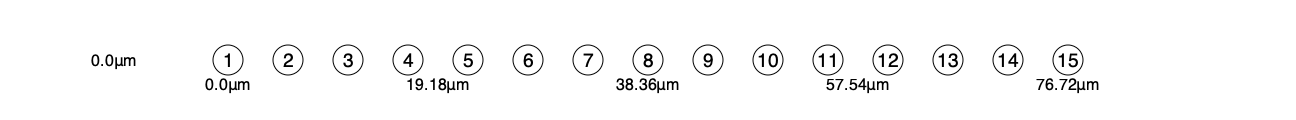

In [2]:
# nsites equidistant sites with d 
d = 5.48
nsites = 15
atoms = generate_sites(ChainLattice(), nsites, scale = d)

In [3]:
Ω = 2π * 4 # Rabi frequency
Δ_step = 10 # steps in detuning
Δ = LinRange(-2π * 10, 2π * 10, Δ_step); # The range in which the detuning is going to change

In [4]:
density_g = zeros(Δ_step, nsites)
density_check = zeros(Δ_step, nsites)
X1 = [] # for sigma_x(1) expectation per each Hamiltonian 
X5 = [] # for sigma_x(5) expectation per each Hamiltonian 
X9 = [] # for sigma_x(9) expectation per each Hamiltonian 

x1 = chain(nsites, put(1=>Op.X))
x5 = chain(nsites, put(5=>Op.X))
x9 = chain(nsites, put(9=>Op.X))


delta_E = [] # for energy gaps at each Hamiltonian 

for ii in 1:Δ_step
    # the Hamiltonian for each detuning in the sequence
    h_ii = rydberg_h(atoms; Δ = Δ[ii], Ω) 
    h_m = mat(h_ii) # convert the Hamiltonian into a matrix
    # find the ground state eigenvalue and eigenvector per each Hamiltonian
    vals, vecs, info = KrylovKit.eigsolve(h_m, 2, :SR) 
    g_state = ArrayReg(vecs[1]) # Is'nt it the GS of the instantaneous Hamiltonian?
                                
    
    push!(delta_E, vals[2] - vals[1]) # Evaluate E_{1} - E_{0} at each detuning to check Adiabatic Approximation 
    
    
    for jj in 1:nsites
        # measure the density of Rydberg excitations on each site
        density_g[ii, jj] = rydberg_density(g_state, jj)  
        pop = chain(nsites, put(jj=>Op.n))
        density_check[ii, jj] = expect(pop, g_state) # check to see that the 
                                                     #rydberg_density(jj) = < n_{jj} > w.r.t g_state for jj in nsites 
    end
    
        # evaluate \langle \sigma_x \rangle (t) for all sites
        push!(X1,expect(x1, g_state))
        push!(X5,expect(x5, g_state)) 
        push!(X9,expect(x9, g_state))
end


In [13]:
# plot Rydberg density at a detuning (here at the last; change 10 to 1 for getting the first) 
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(1:nsites, density_g[10, :])
ax.set_xticks(1:nsites)
ax.set_xlabel("Sites")
ax.set_ylabel("Rydberg density")
ax.set_title("Density Profile: 1D Chain, Δ = 2π * 10 MHz")
fig
plt.show()
plt.draw()
plt.savefig.("Z2_density_profile.png")


Python None

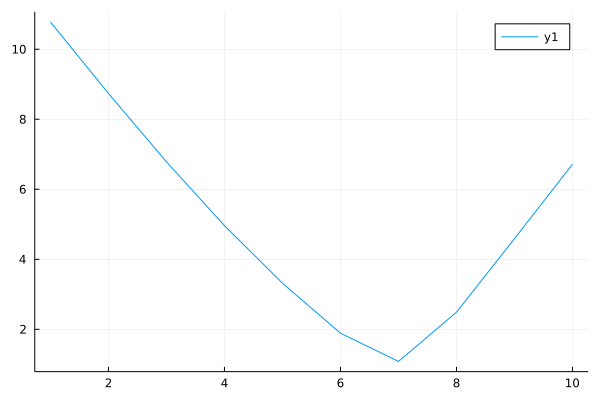

In [43]:
# plot E_{1} - E_{0} as a function of (detuning)
using Plots
x = 1:length(delta_E); 
plot(x, delta_E / 2 / pi)

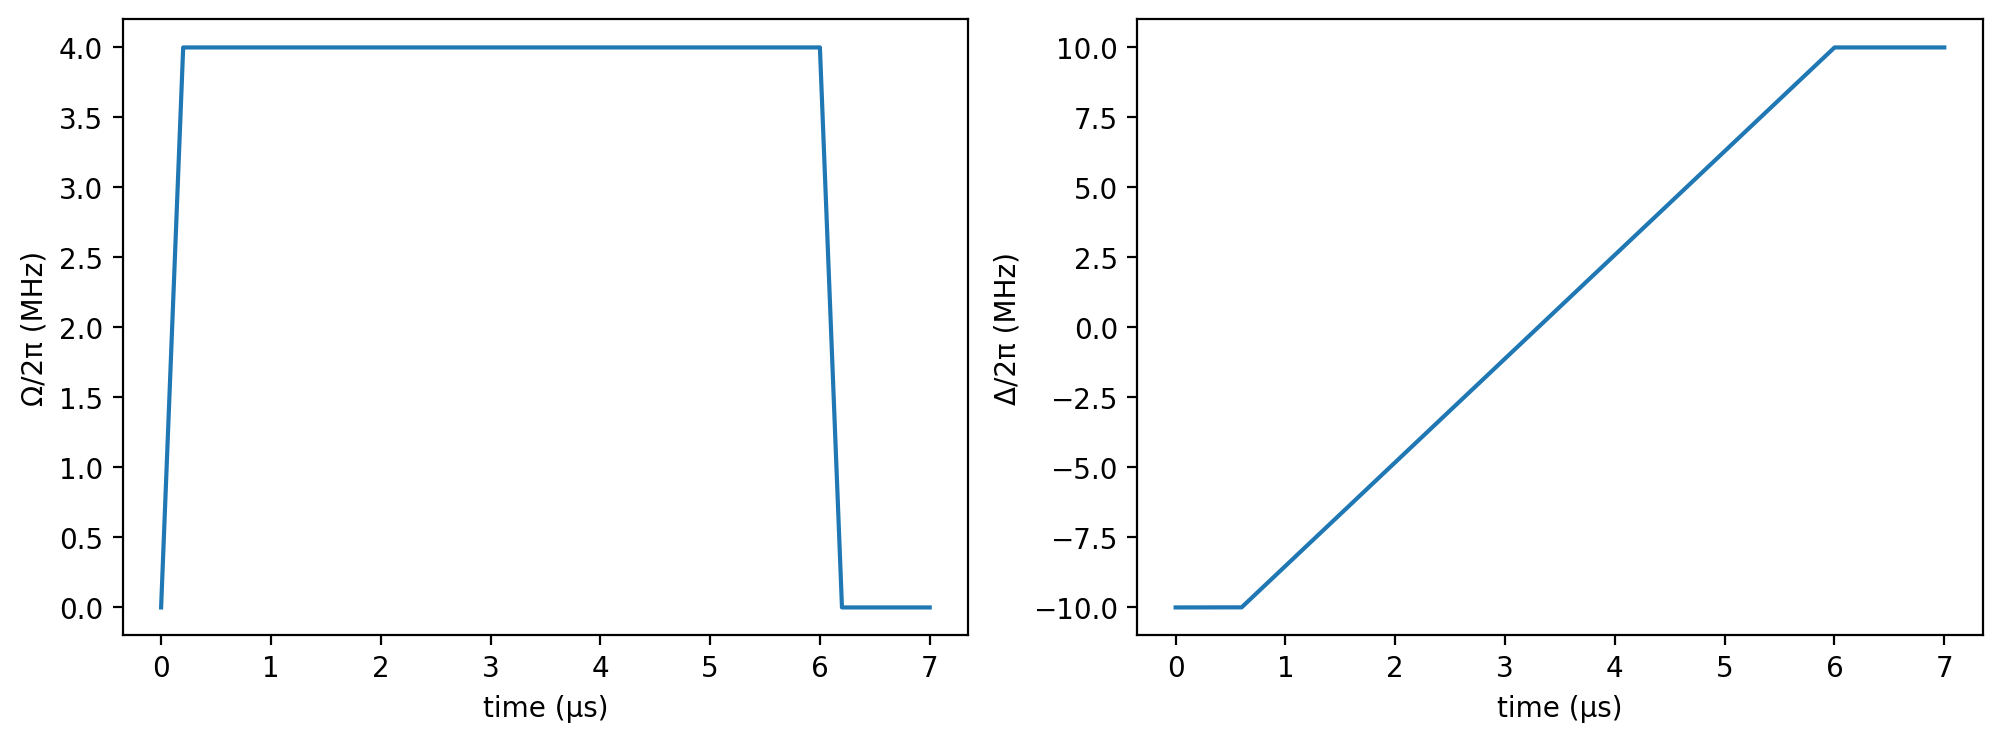

In [74]:
# NOW, we want to evolve the initial Hamiltonian onto the final one in a long-time evolution 

total_time = 7.0; # Total time of evolution
Ω_max = 2π * 4;   # Maximum Rabi frequency in the waveform
Ω = piecewise_linear(clocks = [0.0, 0.2, 6.0, 6.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]); # Rabi waveform

# Detuning waveform
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 6.0, total_time], values = [U1, U1, U2, U2]);

# plot the waveforms
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig



In [75]:
h = rydberg_h(atoms; Δ, Ω) # The Hamiltonian

nqubits: 15
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


In [76]:
# uncomment for full space emulation
#reg = zero_state(nsites); # Ground State 
#prob = SchrodingerProblem(reg, total_time, h);
#integrator = init(prob, Vern8());

# uncomment for subspace emulation
space = blockade_subspace(atoms, 5.48);
reg = zero_state(space)
prob = SchrodingerProblem(reg, total_time, h)
integrator = init(prob, Vern8()); # to save all steps of the evolution
#emulate!(prob)


In [77]:
densities = [] # Rydberg densities meaning the population of |r><r| at each site

for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))  
end

D = hcat(densities...);


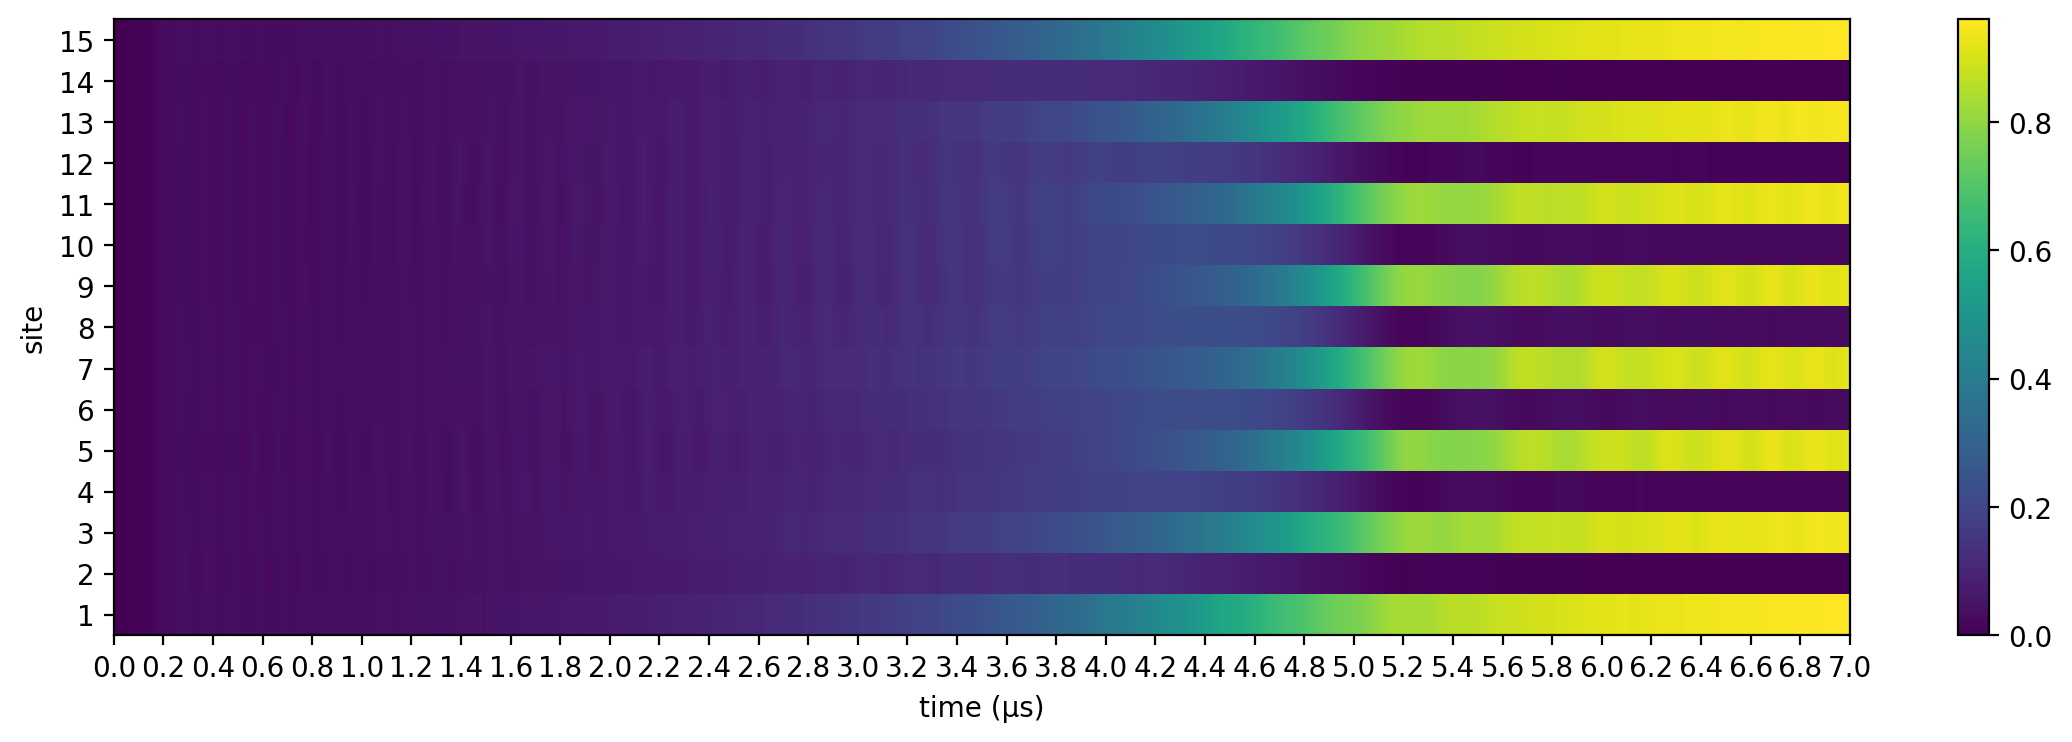

In [78]:
# plot Rydberg density as a function of time
fig, ax = plt.subplots(figsize = (14, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

## Task 2
Full space simulation of higher than 15 atoms takes long (if possible)
But, by eliminating the states that violate the Rydberg blockade (eventhough not perfect) reduces the size of 
our problem, drastically. The question is how are we sure that this truncation is a good approximation?
We are going to do the following to compare the subspace method with the fullspace 

### To do
1. Prepare 11 sites with d = 5.48 and fix the Maximum Rabi frequence according to the recipe
2. Do the simulation for both methods  
3. Plot the Rydberg density as a function of time for both methods

                
### Result:

Compare the full evolution of 11 atoms in the Z2 phase transition with the subspace method (meaning 
eliminating the parts of Hilbert space where two adjacent atoms are in the Rydberg state). We see that the deviation in Rydberg densities are 
more aparent in the middle sites, however all the populations converge in the end.

![Task2](../Images/Task2.png)


## CHALLENGE 2: QAOA (Quantum Approximate Optimisation Algorithm) vs Adiabatic for MIS (Maximum Independent Set) 

### To do           

#### C2.1 Creat a 4 by 4 graph with 20% dropouts   

#### C2.2 Solve classcialy via Tensor Networks

#### C2.3 Do the adiabatic simulation (either fullspace or subspace)

![Challenge2_Adiabatic](../Images/Challenge2_Adiabatic.png)

#### C2.4 Use the QAOA algorithm (arxiv:1411.4028) which is a hybrid quantum-classical algorithm. The classical part is an optimizer, and the quantum part can be a neutral-atom quantum computer first evolving under the Rydberg Hamiltonian parameterized pulse sequences and then being measured in the computational basis. Here, the pulse sequence is 3 periods in detuning/Rabi waveform. 
    
#### Flowchart
    
##### C2.4.1 Evaluate loss (a metric which the more negative the better) with no optimization and no smoothing of the pulse shape
    
##### C2.4.2 Evaluate loss with smooth pulse shapes: Gets better

![Challenge2_Smooth_pulse_shape](../Images/Challenge2_Smooth_pulse_shape.png)

#### C2.4.3 Optimize through the Nelder-Mead method to make the right answers, more probable  

For instance, look at the following sequences, as correct instances:
(1) starts with 1001 and ends with 11 (no more 1s)
(2) starts with 1001 and ends with 10001 (no more 1s) 

![Challenge2_QAOA_Solution](../Images/Challenge2_QAOA_Solution.png)

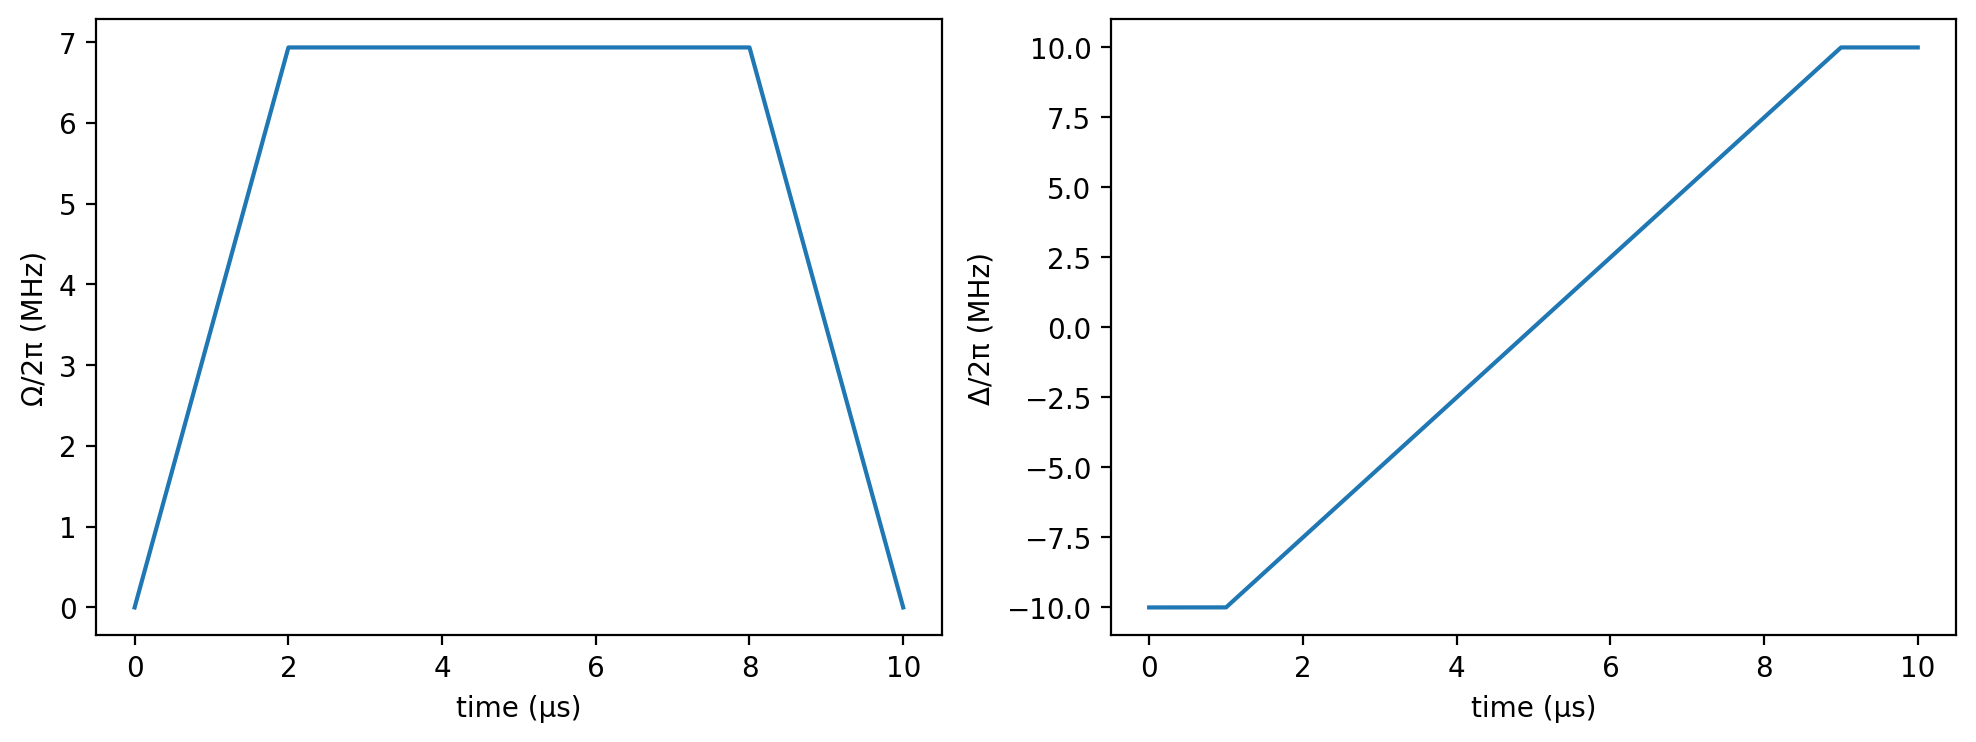

In [2]:
# Compare the subspace approximation with the fullspace
# going to simulate 11 sites for d = 5.48 with both, and compare the rydberg populations 


#### General Characteristics
total_time = 10.0; # Total time of evolution
d = 5.0;           # atomic spacing
Ω_max = 2π * 4 * (5.48 / d)^6; # The Rabi frequency for spacing d according to tutorial
Ω = piecewise_linear(clocks = [0.0, 1/5 * total_time, 4/5 * total_time, total_time], values = [0.0, Ω_max, Ω_max, 0]);

#### nsites equidistant sites with d 
nsites = 11
atoms = generate_sites(ChainLattice(), nsites, scale = d)

#### Detuning waveform
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 1, total_time-1, total_time], values = [U1, U1, U2, U2]);

#### Hamiltonian
h = rydberg_h(atoms; Δ, Ω)


# full space emulation
reg = zero_state(nsites); # Ground State 
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());
densities_full = []

for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities_full, rydberg_density(reg))  
end

D1 = hcat(densities_full...); # Rydberg desities

# subspace emulation
space = blockade_subspace(atoms, d);
reg = zero_state(space)
prob = SchrodingerProblem(reg, total_time, h)
integrator = init(prob, Vern8());

densities_check = []          # Rydberg desities

for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities_check, rydberg_density(reg))  
end

D2 = hcat(densities_check...);


#### plot the difference in two methods
# plot the waveforms
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

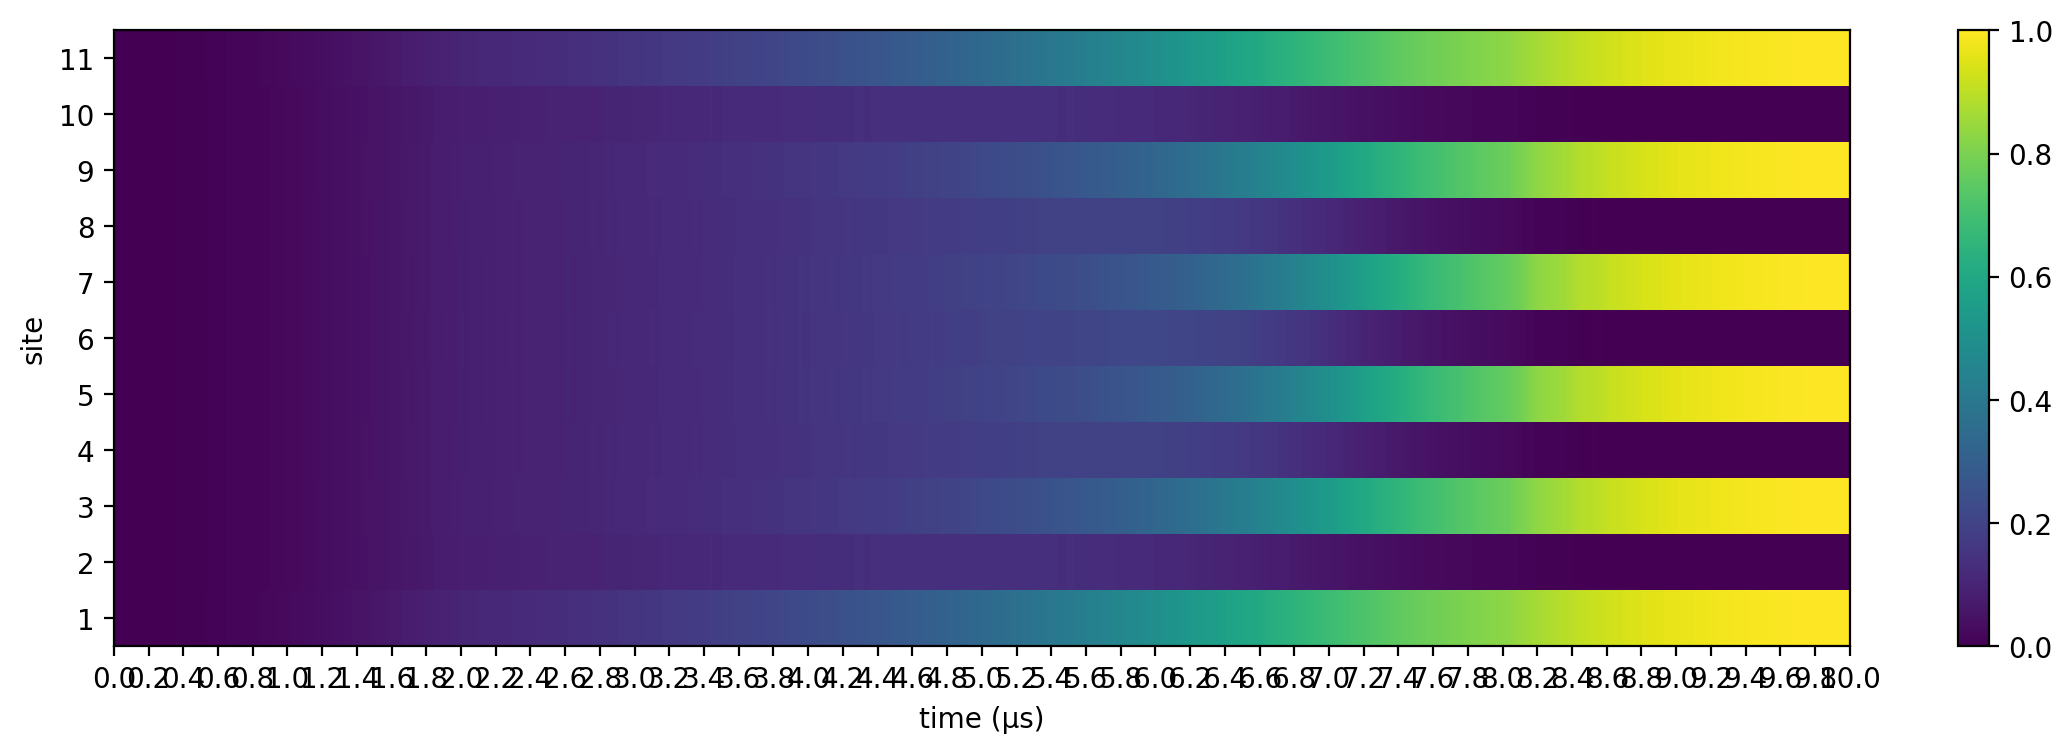

In [3]:
# plot Rydberg density for either method (full or sub-space) as a function of time to check
# whether each one ends up in Z2 state
fig, ax = plt.subplots(figsize = (14, 4))
shw = ax.imshow(real(D1), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

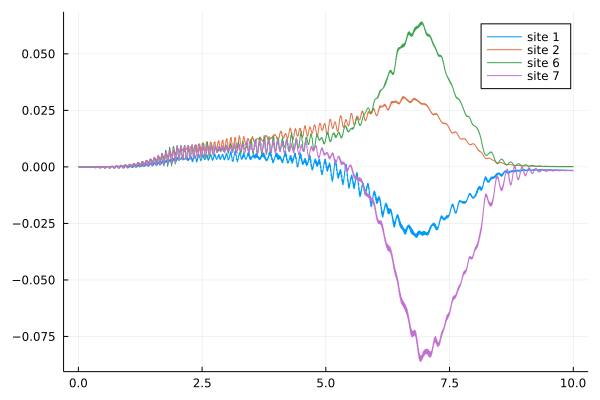

In [4]:
# Here, we compare the full evolution of 11 atoms in the Z2 phase transition with the subspace method meaning 
# eliminating the parts of Hilbert space where two adjacent atoms are in the Rydberg state. The Rabi 
# frequency is picked via the suggestion in the Tutorial. We see that the deviation in Rydberg densities are 
# more aparent in the middle sites, however all the populations converge in the end.

using Plots
fig
x = 1:length(densities_full); 
p1 = plot(x / 1000, D1[1,:]-D2[1,:], label = "site 1")
p2 = plot!(p1, x / 1000, D1[2,:]-D2[2,:], label = "site 2")
p3 = plot!(p2, x / 1000, D1[6,:]-D2[6,:], label = "site 6")
p4 = plot!(p3, x / 1000, D1[7,:]-D2[7,:], label = "site 7")

# plt.show()
#plt.draw()
#plt.savefig.("Compare_Full_with_Subspace.png")

In [3]:
#### CHALLENGE 2: QAOA (Quantum Approximate Optimisation Algorithm) 
#### vs Adiabatic for MIS (Maximum Independent Set) 

using Bloqade
using PythonCall
using Graphs
using Random
using GenericTensorNetworks
import Pkg; Pkg.add("Optim")
using Optim



   Resolving package versions...
   Installed PositiveFactorizations ─ v0.2.4
   Installed Optim ────────────────── v1.7.0
    Updating `~/.julia/environments/v1.7/Project.toml`
  [429524aa] + Optim v1.7.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [429524aa] + Optim v1.7.0
  [85a6dd25] + PositiveFactorizations v0.2.4
Precompiling project...
  ✓ PositiveFactorizations
  ✓ Optim
  2 dependencies successfully precompiled in 5 seconds (319 already precompiled)


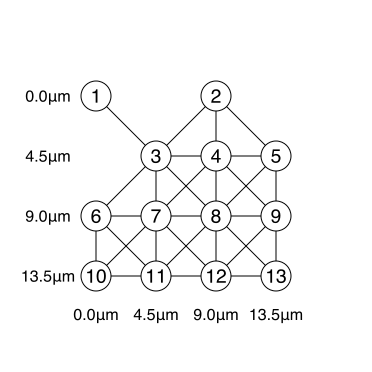

In [4]:
# Creat a 4 by 4 graph with 20% dropouts
Random.seed!(2)
atoms = generate_sites(SquareLattice(), 4, 4; scale = 4.5) |> random_dropout(0.2)

Bloqade.plot(atoms, blockade_radius = 7.5)


In [5]:
# Classical Solution via Tensor Networks
graph = BloqadeMIS.unit_disk_graph(atoms, 7.5)
mis_size_and_counting = GenericTensorNetworks.solve(IndependentSet(graph), CountingMax())[]

(4.0, 26.0)ₜ

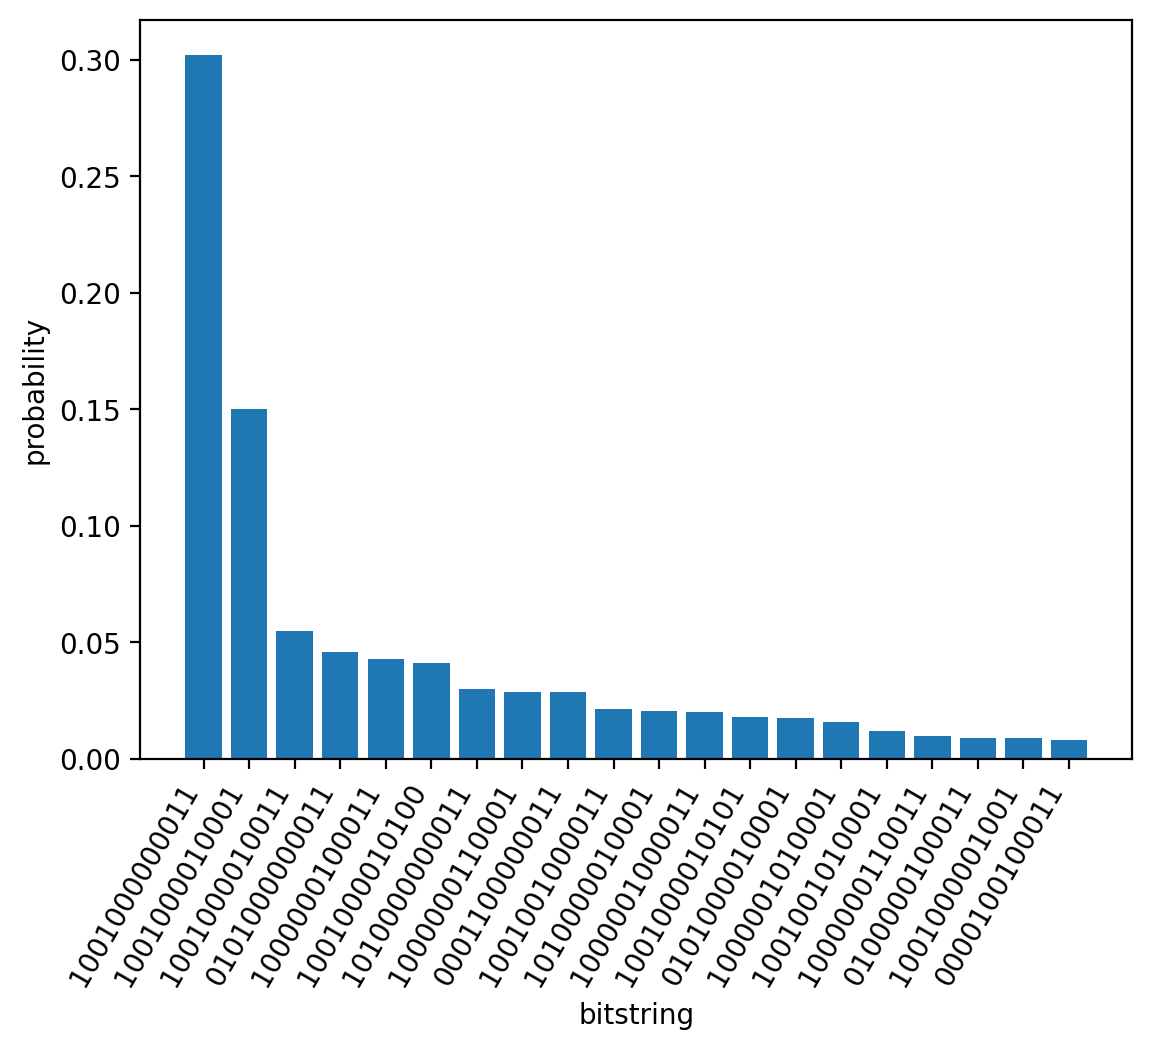

In [6]:
# Adiabatic Approach
T_max = 0.6  # Total time of evolution
Ω_max = 2π * 4 # Maximum Rabi frequency in the waveform
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -2π * 13 # starting detuning
Δ_end = 2π * 11    # finishing detuning
# detuning waveform 
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
emulate!(prob)

bitstring_hist(prob.reg; nlargest = 20)

In [7]:
# Compare to the classical solution obtained via Tensor Networks
best_bit_strings = most_probable(prob.reg, 2)
all_optimal_configs = GenericTensorNetworks.solve(IndependentSet(graph), ConfigsMax())[]
@assert all(bs -> GenericTensorNetworks.StaticBitVector([bs...]) ∈ all_optimal_configs.c, best_bit_strings)


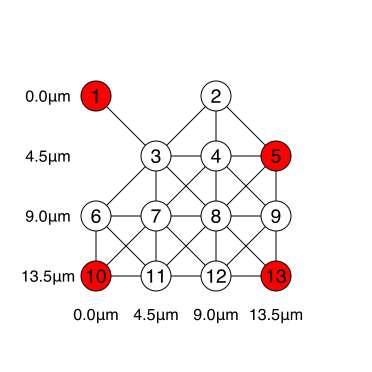

In [254]:
# Visualize the most probable solution in the Adiabatic method
Bloqade.plot(atoms, blockade_radius = 7.5; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])


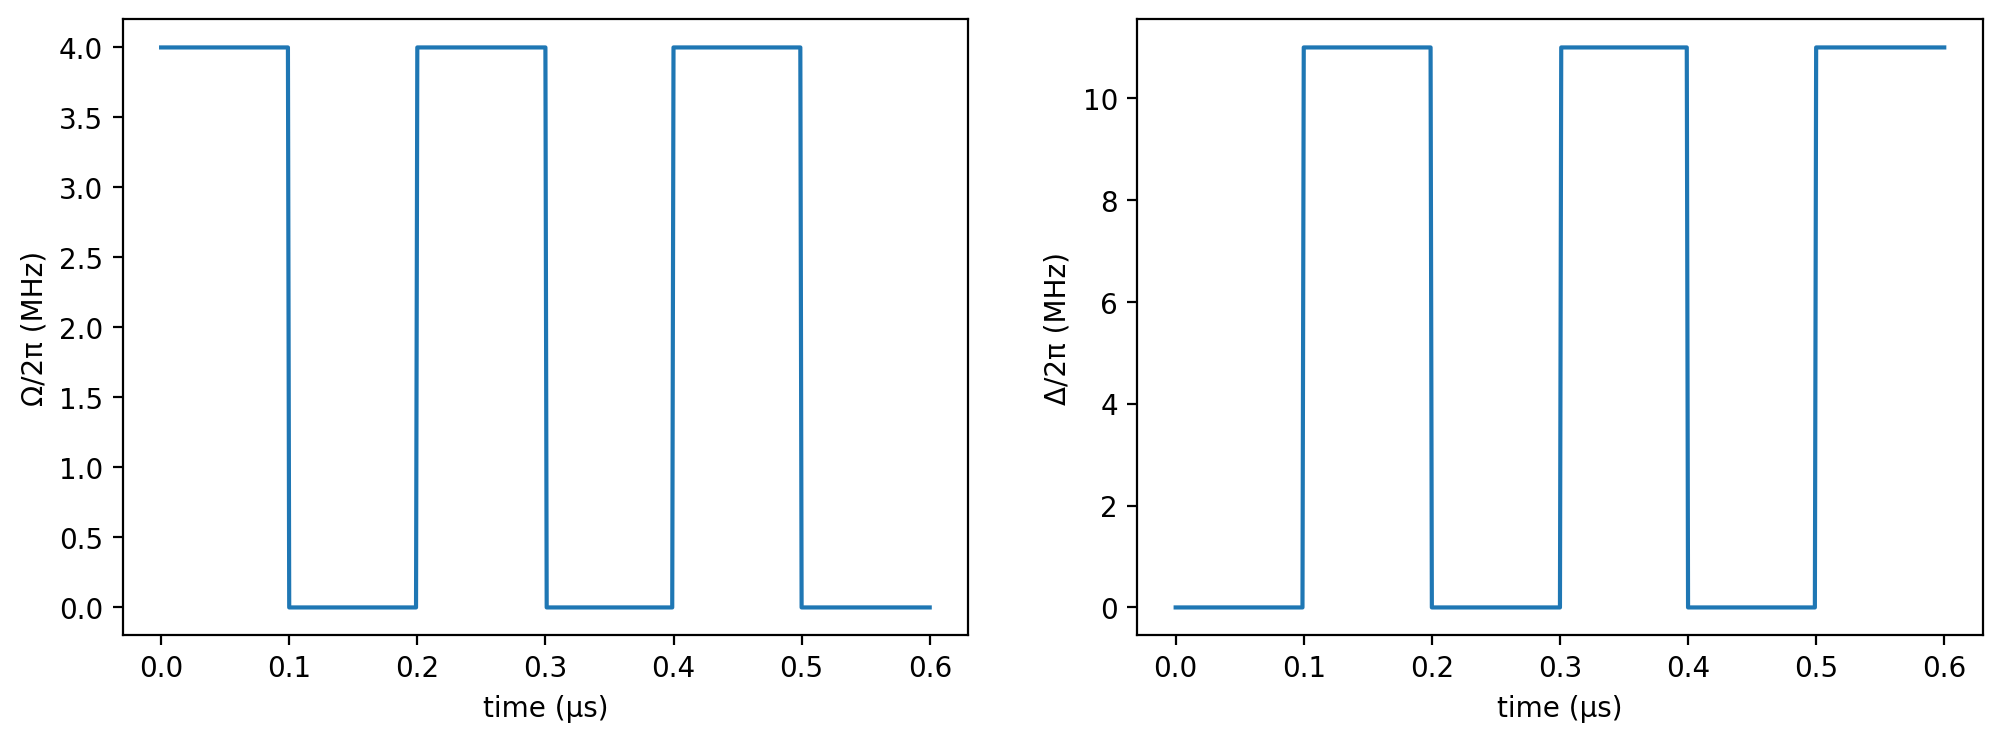

In [8]:
# QAOA Approach
# The QAOA algorithm (arxiv:1411.4028) is a hybrid quantum-classical algorithm. 
# The classical part of the algorithm is an optimizer, and the corresponding quantum part can be a 
# neutral-atom quantum computer first evolving under the Rydberg Hamiltonian 
# parameterized pulse sequences and then being measured in the computational basis.


# Pulse sequence of p=3 meaning 3 periods in detuning/Rabi waveform
durations = fill(0.1, 6)
clocks = [0, cumsum(durations)...]
Ω2 = piecewise_constant(; clocks = clocks, values = repeat([Ω_max, 0.0], 3))
Δ2 = piecewise_constant(; clocks = clocks, values = repeat([0.0, Δ_end], 3))

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω2)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ2)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [9]:
# This time, we simulate the dynamics in the subspace generated by the blockade_subspace 
# so that we do not need postprocessing anymore. 

hamiltonian2 = rydberg_h(atoms; Ω = Ω2, Δ = Δ2)
nsites = length(atoms)
subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
prob2 = KrylovEvolution(zero_state(subspace), clocks, hamiltonian2)
emulate!(prob2);


In [10]:
# evaluate loss with no optimization and no smoothing of the pulse shape 
# compare the loss cost (the more negative the better)

loss_MIS(reg) = -rydberg_density_sum(prob2.reg)
loss_MIS(prob2.reg)


-2.562886912802683

In [11]:
# evaluate the loss for piecewise constant waveform in a function to be called later
function loss_piecewise_constant(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) % 2 == 0
    Ω_max = 4 * 2π
    Δ_end = 11 * 2π
    p = length(x) ÷ 2

    # detuning and rabi terms
    durations = abs.(x)   # the durations of each layer of the QAOA pulse take the optimizing vector x as their input
    clocks = [0, cumsum(durations)...]
    Ωs = piecewise_constant(; clocks = clocks, values = repeat(T[Ω_max, 0.0], p))
    Δs = piecewise_constant(; clocks = clocks, values = repeat(T[0.0, Δ_end], p))

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)  # we run our simulation within the blockade subspace
    prob = KrylovEvolution(zero_state(Complex{T}, subspace), clocks, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg
end


loss_piecewise_constant (generic function with 1 method)

In [12]:
# generating the same result as the last step
x0 = durations
rydberg_density, reg1 = loss_piecewise_constant(atoms, x0)
rydberg_density


-2.562886912802683

In [13]:
# function to evaluate loss with smoothed pulse shapes

function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 3
    Ω_max = 4 * 2π
    Δ_start = -13 * 2π
    Δ_end = 11 * 2π
    Δ0 = 11 * 2π
    T_max = 0.6

    # the strength of the detunings at each step takes the optimizing x as their input
    Δs = smooth(
        piecewise_linear(
            clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ_end, Δ_end],
        );
        kernel_radius = 0.02,
    )
    Ωs = smooth(
        piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.5, 0.55, T_max], values = T[0, 0, Ω_max, Ω_max, 0, 0]);
        kernel_radius = 0.02,
    )

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, 7.5)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Δs
end



loss_piecewise_linear (generic function with 1 method)

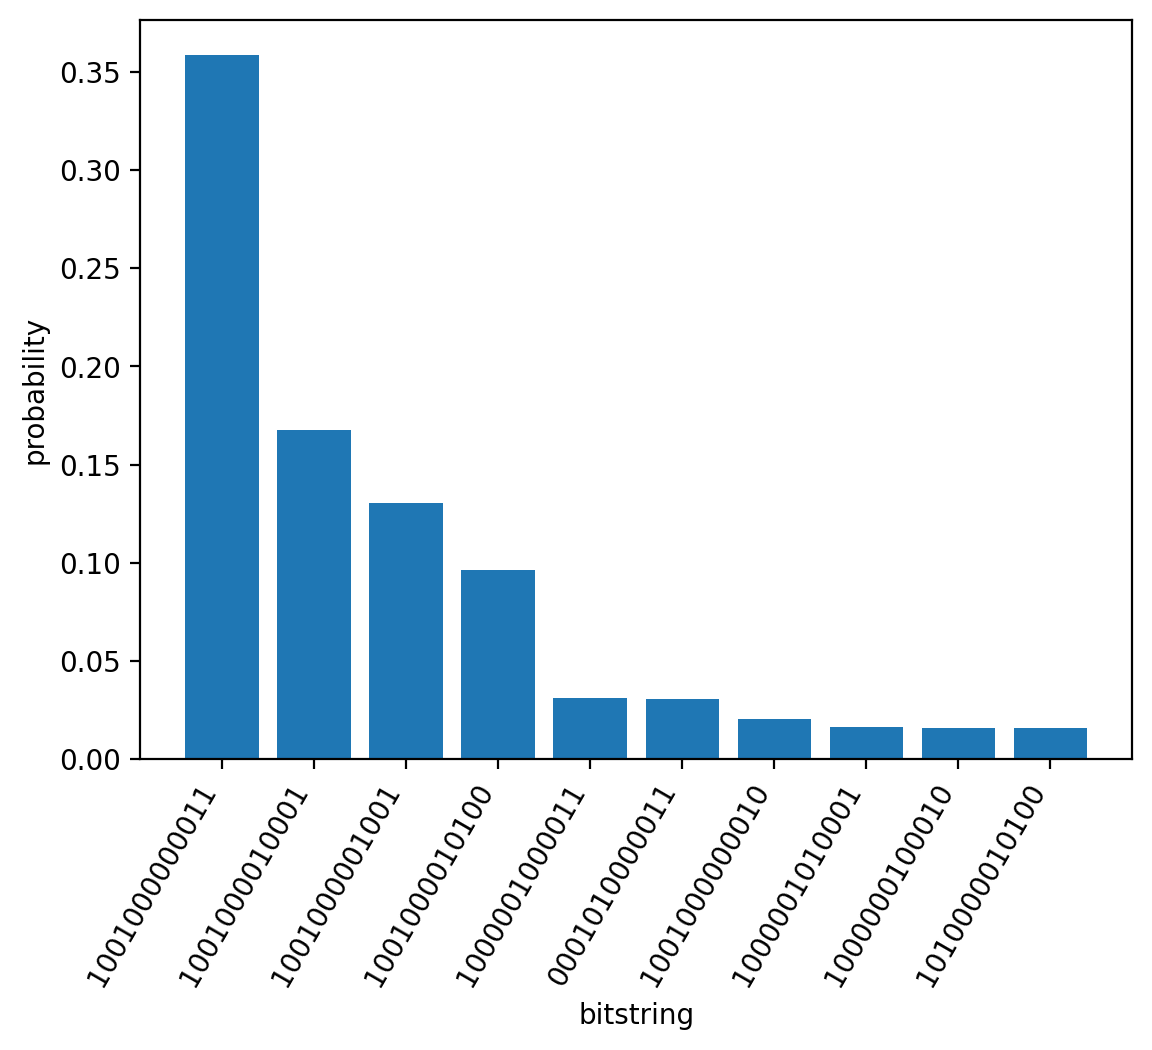

In [14]:
# check the loss function (remember: the more negative the better!)
x0 = [0.1, 0.8, 0.8]; # initial point for the optimization
Δ_start = -13 * 2π
Δ_end = 11 * 2π
Δ0 = 11 * 2π
T_max = 0.6
Δ_initial = piecewise_linear(
    clocks = [0.0, 0.05, 0.2, 0.3, 0.4, 0.55, T_max],
    values = [Δ_start, Δ_start, Δ0 * x0[1], Δ0 * x0[2], Δ0 * x0[3], Δ_end, Δ_end],
)

rydberg_density, reg2, Δ_initial_smooth = loss_piecewise_linear(atoms, x0)

bitstring_hist(reg2; nlargest = 10)



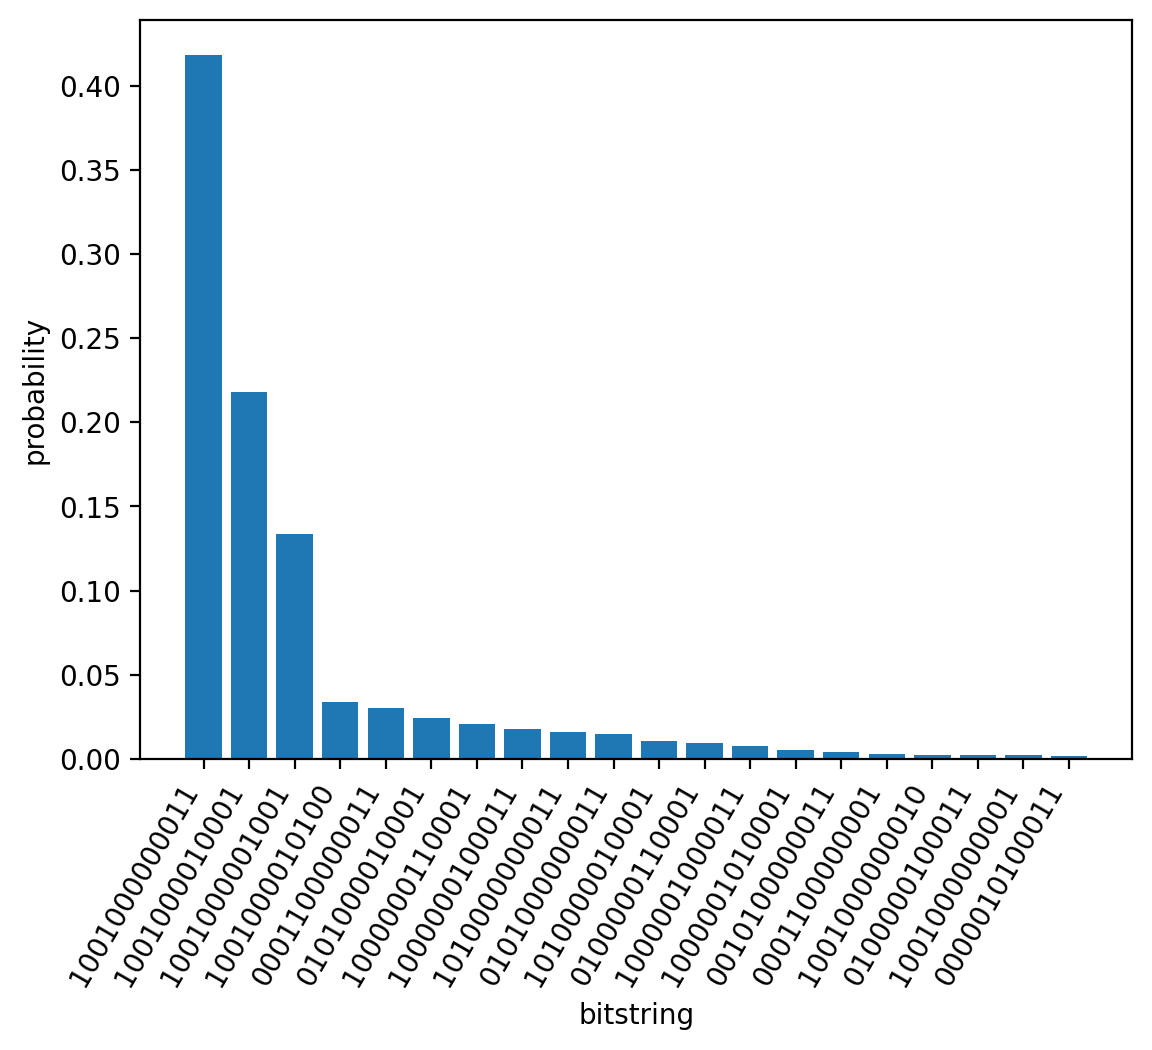

In [15]:
# Nelder-Mead optimisation to make the right answers, more probable 
# look at the following sequences, as correct instances:
# (1) starts with 1001 and ends with 11 (no more 1s)
# (2) starts with 1001 and ends with 10001 (no more 1s) 


optresult = Optim.optimize(x -> loss_piecewise_linear(atoms, x)[1], x0)

rydberg_density_final, reg_final, Δ_final = loss_piecewise_linear(atoms, optresult.minimizer)
rydberg_density_final

bitstring_hist(reg_final; nlargest = 20)

